In [1]:
import pandas as pd
import gensim
file_path = "../data/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)

train = pd.read_csv("../data/train.txt", sep="\t")
valid = pd.read_csv("../data/valid.txt", sep="\t")
test = pd.read_csv("../data/test.txt", sep = "\t")

In [3]:
#70
import numpy as np
def get_mean_vec(df):
    result=[]
    for sentence in df.TITLE.values:
        words_vec=[]
        for word in sentence.split(" "):
            try:
                words_vec.append(word2vec[word].tolist())
            except:
                continue
        if len(words_vec)>0:
            result.append(np.array(words_vec).mean(axis=0).tolist())
        else:
            result.append([0]*300)
    return np.array(result)

X_train = get_mean_vec(train)
X_valid = get_mean_vec(valid)
X_test = get_mean_vec(test)

from sklearn.preprocessing import LabelEncoder
#LabelEncoderのインスタンスを生成
le = LabelEncoder()
#ラベルを覚えさせる
le = le.fit(train.CATEGORY.values)
#ラベルを整数に変換

y_train = le.transform(train.CATEGORY.values)
y_valid = le.transform(valid.CATEGORY.values)
y_test = le.transform(test.CATEGORY.values)

In [4]:
#71
import torch
import torch.nn as nn
import torch.nn.functional as F

dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

class singleLP(nn.Module):
    def __init__(self):
        super(singleLP, self).__init__()
        self.fc=nn.Linear(300, 4)
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        return self.softmax(self.fc(x))    
model = singleLP()

device: cpu


In [5]:
def to_tensor(array):
    return torch.tensor(array, dtype=dtype, device=device)

X_train = to_tensor(X_train)
X_valid = to_tensor(X_valid)
X_test = to_tensor(X_test)
y_train = to_tensor(y_train).long()
y_valid = to_tensor(y_valid).long()
y_test = to_tensor(y_test).long()

In [6]:
#72#73
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters() , lr=0.3, momentum=0.9)

epochs=100
for epoch in range(epochs):
    optimizer.zero_grad()
    hat_y = model(X_train)
    loss=criterion(hat_y, y_train)
    print("{}/{}epoch loss : {}".format(epoch+1, epochs,loss))
    loss.backward()
    optimizer.step()

1/100epoch loss : 1.380776047706604
2/100epoch loss : 1.3767211437225342
3/100epoch loss : 1.3690412044525146
4/100epoch loss : 1.3581953048706055
5/100epoch loss : 1.344656229019165
6/100epoch loss : 1.3289766311645508
7/100epoch loss : 1.3117291927337646
8/100epoch loss : 1.2935017347335815
9/100epoch loss : 1.2748438119888306
10/100epoch loss : 1.2562077045440674
11/100epoch loss : 1.2379579544067383
12/100epoch loss : 1.220323085784912
13/100epoch loss : 1.2034624814987183
14/100epoch loss : 1.1874427795410156
15/100epoch loss : 1.1722941398620605
16/100epoch loss : 1.1580151319503784
17/100epoch loss : 1.144620418548584
18/100epoch loss : 1.132119059562683
19/100epoch loss : 1.1205358505249023
20/100epoch loss : 1.1098718643188477
21/100epoch loss : 1.1001224517822266
22/100epoch loss : 1.0912550687789917
23/100epoch loss : 1.0832103490829468
24/100epoch loss : 1.0759059190750122
25/100epoch loss : 1.0692821741104126
26/100epoch loss : 1.0632423162460327
27/100epoch loss : 1.05773

In [7]:
#74
_, label=torch.max(model(X_train), 1)
correct=(label==y_train).sum().item()
print("train_acc : ", correct/label.size(0))

_, label=torch.max(model(X_valid), 1)
correct=(label==y_valid).sum().item()
print("valid_acc : ", correct/label.size(0))

train_acc :  0.7827961019490255
valid_acc :  0.7653673163418291


In [54]:
#75#76#79
import matplotlib.pyplot as plt
def get_acc(y_hat, y):
    _, label=torch.max(y_hat, 1)
    correct=(label==y).sum().item()
    return correct/label.size(0)
model=singleLP()

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1=nn.Linear(300, 512)
        self.fc2=nn.Linear(512,512)
        self.fc3=nn.Linear(512,4)
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        h=F.relu(self.fc1(x))
        h=F.relu(self.fc2(h))
        h=self.fc3(h)
        return self.softmax(h)

model=MLP()
batch_size=128
epochs=30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters() , lr=0.01, momentum=0.9)
def train_model(epochs, net):
    train_loss=[]
    train_acc=[]
    valid_loss=[]
    valid_acc=[]
    for epoch in range(epochs):
        for idx in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            hat_train_y = net(X_train[idx : idx+batch_size if idx+batch_size<=len(X_train) else len(X_train)])
            loss=criterion(hat_train_y, y_train[idx : idx+batch_size if idx+batch_size<=len(X_train) else len(X_train)])
            loss.backward()
            optimizer.step()
        torch.save(net, "../checkpoint/checkpoin_{}.pt".format(epoch+1))
        
        with torch.no_grad():
            hat_train_y=net(X_train)
            train_loss.append(criterion(hat_train_y, y_train))
            train_acc.append(get_acc(hat_train_y,y_train))
            #検証用

            hat_valid_y = net(X_valid)
            valid_loss.append(criterion(hat_valid_y, y_valid))
            valid_acc.append(get_acc(hat_valid_y,y_valid))
    return train_loss, train_acc, valid_loss, valid_acc
train_loss, train_acc, valid_loss, valid_acc=train_model(epochs, model)

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


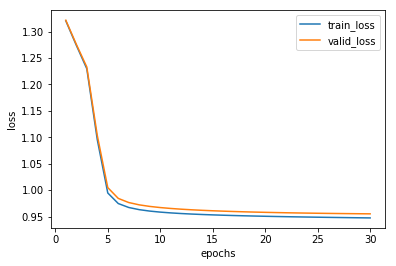

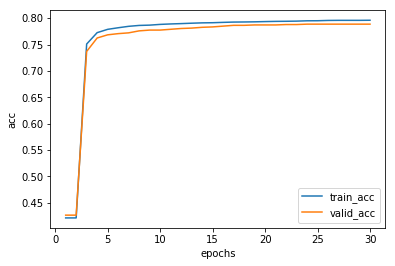

In [55]:
plt.plot([i+1 for i in range(epochs)], train_loss, label="train_loss")
plt.plot([i+1 for i in range(epochs)], valid_loss, label="valid_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.plot([i+1 for i in range(epochs)], train_acc, label="train_acc")
plt.plot([i+1 for i in range(epochs)], valid_acc, label="valid_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [10]:
#77
import time
batch_list=[1,2,4,8,16,32,64,128,256,512]
mean_time=[]
for batch_size in batch_list:
    model=singleLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters() , lr=0.01, momentum=0.9)
    epochs=10
    totall_time=0
    for epoch in range(epochs):
        start=time.time()
        for idx in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            hat_train_y = model(X_train[idx : idx+batch_size if idx+batch_size<=len(X_train) else len(X_train)])
            loss=criterion(hat_train_y, y_train[idx : idx+batch_size if idx+batch_size<=len(X_train) else len(X_train)])
            loss.backward()
            optimizer.step()
        end = time.time()
        totall_time+=end-start
    mean_time.append(totall_time/epochs)

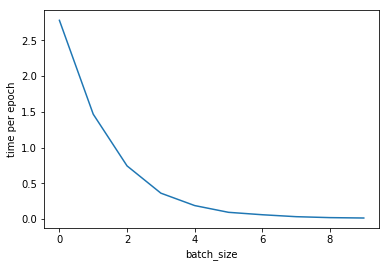

In [11]:
plt.plot(np.log2(batch_list), mean_time)
plt.xlabel("batch_size")
plt.ylabel("time per epoch")
plt.show()

In [48]:
#78略